### JCU MA5851
<p style="line-height: 1.5; font-size:12pt">
    Student:   Sacha Schwab <br>
    Location:  Zurich, Switzerland<br>
    Date:      8 December 2021
</p>


# Assessment 3 - Code for Part Three (NLP)

<b style="line-height: 1.5; font-size:12pt">Code structure:</b>
<p style="line-height: 1.5; font-size:12pt">
Imports and necessary functions for a standard model build pipeline are defined, then the pipeline function runs these jobs:<br>
Pipeline:<br>

<ul style="line-height: 1.5; font-size:12pt">
  <li>Data wrangling<br>
        - preprocess<br>
        - visualise + describe corpus<br></li>
  <li>NLP<br>
        - vectorise<br>
        - add entities<br>
        - add sentiments<br></li>
  <li>Machine learning<br>
        - build hdbscan model<br>
        - save model</p></li>
</ul>   

<b style="line-height: 1.5; font-size:14pt">Please note:</b>
<ul style="line-height: 1.5; font-size:12pt">
  <li>Code integrates model evaluation. Since dbscan was also evaluated I will leave the respective code in case of interest.</li>
  <li>This is the tutorial-style code. "daily_jobs" folder has the code version for dev/ops team, i.e. for<br>
            - running the daily model build job (logically with preliminary preprocessing + nlp steps)<br>
            - model use</li>
   <li>Flaw in the naming of dataframe columns: 'title_prepped' should actually be named 'title_corpus', etc. Due to available time running out I was not able to correct this. Will happen in the next release.</li>
   <li>Also a little flaw: 'text' below actually means 'body_text' of the articles.</li>
</ul>

## Data wrangling

In [ ]:
# Imports and downloads
import pandas as pd
import numpy as np

import os
import pickle
import hdbscan
import seaborn as sns
from pylab import rcParams
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

from pprint import pprint
from string import digits

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

import spacy
from spacy import displacy
from collections import Counter
# Get the following with: python -m spacy download en_core_web_sm
import en_core_web_sm

In [4]:
# Static values
dir_path = 'data/'
raw_file_name = 'raw_data.csv'
stop_words = stopwords.words('english')

In [5]:
# Under construction 
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lem_text = []
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word)
        lem_text.append(lem_word)
    return(lem_text)

def lower_text(text):
    return(text.lower())

def erase_symbols(text):
    symbols = "!\"#$%&()*+-—,/<=>?@[\]^_`{|}~\n"
    out_text = out_text.replace(i, ' ')
    return(out_text)

def erase_stopwords(text):
    return 0

In [6]:
def prep_data_column(column):
    '''
        Pre-process text for an entire column
        Input: List (dataframe column) with text
        Output: Pre-processed text
    '''
    prepped_col = []
    for text in column:
        # Check if there is actually text
        if (len(text) > 0):
            prepped_text = prep_text(text)
        else:
            prepped_text = ''
        prepped_col.append(prepped_text)
    return(prepped_col)

In [7]:
def prep_text(text):
    '''
        Pre-process text pipeline
        Input: A text (string)
        Output: Pre-processed text
    '''
    # Initialise lemmatizer for later use
    lemmatizer = WordNetLemmatizer()
    
    out_text = text.lower()

    # Remove numbers
    remove_digits = str.maketrans('', '', digits)
    out_text = out_text.translate(remove_digits)
    
    # Erase symbols, vary for the case sentence stop 
    # characters needed (e.g. for BERT)
    symbols = "!\"#$%&()*+-.—,/:;<=>?@[\]^‘’_`{|}~[],''\n"
    for i in symbols:
        out_text = out_text.replace(i, ' ')
    # Exclude stop words. Exclude single character words
    splitted_text = out_text.split()
    stopped_text = ""

    for word in splitted_text:
        if word not in stop_words and len(word) > 1:
            # Exclude apostrophe
            word = word.replace('”', '')
            word = word.replace('“', '')
            word = word.replace("'", "")
            # Lemmatize
            word = lemmatizer.lemmatize(word)
            # Compose text. Some words may have 'shrunken' to 
            # one character. Eliminate these.
            if len(word) > 1:
                stopped_text = stopped_text + ' ' + word

    out_text = stopped_text

    return(out_text.strip())

In [8]:
### Test function above ####
# text = "hoi du wie gahts? s,cho 87lang 99nüm gsee!!!"
# prep_text(text)


In [9]:
def preprocess_data(file_path):
    ''' 
        Takes a title + text dataframe and preprocesses the text data
        Input: Path to the file that should be preprocessed
        Output: Dataframe with original columns and columns with preprocessed data
        Uses custom Defs: def prep_data_column which usues
                            def prep_text
    '''
    
    df_raw = pd.read_csv(file_path)
    
    # Prepare df to hold the preprocessed data
    columns = ['title', 'text', 'date_time']
    text_cols = ['title', 'text']
    df_prep = pd.DataFrame(columns=columns)

    for col in columns:
        df_prep[col] = df_raw[col]
        
    for col in text_cols:
        prep_col = prep_data_column(df_raw[col])
        # Add preprocessed data 
        df_prep[col + '_prepped'] = prep_col
    # Convert date-time
    df_prep['date'] = df_prep['date_time'].apply(lambda x: datetime.strptime(x, '%B %d, %Y, %I:%M %p').strftime('%Y-%m-%d'))
    return df_prep

In [10]:
### TEST cell above ###
# df = preprocess_data(dir_path + file_name)
# df.head()

In [11]:
def build_corpus(df):
    ''' 
        Build corpus of titles and articles body (text)
        Input: Dataframe with title and text (body) rows
        Output: Columns having corpus and merged text
    '''
    
    title_corpus = []
    titles_merged = []
    for title in df['title_prepped']:
        spl = title.split()
        title_corpus.append(spl)
        for word in spl:
            titles_merged.append(word)
    fdist_filtered_titles = FreqDist(titles_merged)
    
    text_corpus = []
    text_merged = []
    for text in df['text_prepped']:
        spl = text.split()
        text_corpus.append(spl)
        for word in spl:
            text_merged.append(word)
    
    df['title_corpus'] = title_corpus
    df['text_corpus'] = text_corpus
    df['merged_corpus'] = df['title_prepped'] + df['text_prepped']
    
    return(df)

In [12]:
def visualise_corpus(df):
    ''' 
        Basic visualisation of corpus
        Input: Corpus parts
        Output: Visuals
    '''
    
    df['corpus_merged'] = df['title_prepped'] + ' ' + df['text_prepped']
    
    # Most frequent words plots
    fdist_text = FreqDist(sum(df['text_prepped'].map(word_tokenize), []))
    fdist_titles = FreqDist(sum(df['title_prepped'].map(word_tokenize), []))
    plt.rcParams["figure.figsize"] = (20,5)
    fdist_titles.plot(80,title='Frequency distribution of 80 most common tokens in title corpus')
    
    
    plt.rcParams["figure.figsize"] = (20,5)
    fdist_text.plot(80,title='Frequency distribution of 80 most common tokens in text corpus')
    
    # Frequency distribution plots
    fig, axs = plt.subplots(2, figsize=(15,10))
    fig.suptitle('Frequency distribution of words in corpus')
    
    bcounts_titles = [i for i in fdist_titles.values() if i >= 10]
    bins_titles = range(10, 150, 1)
    axs[0].hist(bcounts_titles, bins = bins_titles)
    
    bcounts_text = [i for i in fdist_titles.values() if i >= 20]
    bins_text = range(20, 1400, 10)
    axs[1].hist(bcounts_text, bins = bins_text)

    axs[0].title.set_text('Distribution of word count in titles for counts >= 10')
    axs[1].title.set_text('Distribution of word count in text for counts >= 20')
    axs[1].set_xlabel('Counts')
    axs[0].set_ylabel('Number of words')
    axs[1].set_ylabel('Number of words')

    return(df)

In [13]:
def descriptive_statistics(df):
    ''' 
        Print some descriptive statistics of article title and body (text) columns
        Input: Corpus parts
        Output: Prints of mean lengths, total corpus size
    '''
    titles_merged = ' '.join(df['title_prepped'].tolist())
    text_merged = ' '.join(df['text_prepped'].tolist())
    title_corpus = df['title_corpus']
    text_corpus = df['text_corpus']
    print('------ Descriptive statistics of preprocessed dataset -------')
    print('Number of documents: ' + str(len(title_corpus)))
    print('Date range: From ' + min(df['date']) + ' to: ' + max(df['date']))
    title_lengths = [len(i) for i in title_corpus]
    mean_title_length = sum(title_lengths) / len(title_lengths)
    text_lengths = [len(i) for i in text_corpus]
    mean_text_length = sum(text_lengths) / len(text_lengths)
    
    print('Mean length of titles: ' + str(mean_title_length))
    print('Mean length of article body texts: ' + str(mean_text_length))
    print('Total corpus size: ' + str(len(titles_merged) + len(text_merged)))

## Embedding - TF-IDF

In [15]:
def get_tfidf(corpus):
    ''' 
        Build TF-IDF matrix for a given corpus
        Input: Corpus (Preprocessed text strings)
        Output: TF-IDF matrix, the vectorizer object
            (having the labels)
        TODO next version: Limit to TfidfTransformer
    '''
    # Initiate vectorizer
    vectorizer = TfidfVectorizer(analyzer='word')
    # Form the matrix
    tfidf_matrix = vectorizer.fit_transform(corpus)
    # Investigate the shape of the matrix
    print('TF-IDF matrix shape: ' + (str(tfidf_matrix.shape)))
    
    return(tfidf_matrix, vectorizer)

In [16]:
### TEST cell above ###
# get_tfidf(df['merged_corpus'])

## Keywords

In [55]:
def add_keywords(df, x_keywords, tfidf_matrix, vectorizer):
    ''' 
        Based on TF-IDF, extract x keywords i.e.
            words with highest weights in the order of 
            their appearance in the corpus
        Input: Dataframe of articles, preprocessed text + corpus
        Output: Dataframe with keyword columns
    '''

    # Get TF-IDF matrix (holding the weights) and vectorizer 
    # object (holding the labels)
    names = vectorizer.get_feature_names_out()
    # Convert to operable format
    weights = tfidf_matrix.todense().tolist()
    # Create a dataframe with the results
    weights_df = pd.DataFrame(weights, columns=names)

    # Add empty columns to hold the x keywords and their weights
    df['keywords'] = ''
    df['keyword_weights'] = ''

    # Loop through merged corpus text
    for i in range(0, len(df)):
        text = df['text_corpus'][i]
        vector = []
        # Look up the weight of each word in the TF-IDF 
        # document-weights-per token matrix
        for word in text:
            if word in weights_df:
                weight = weights_df[word][i]
                vector.append(weight)
            else:
                vector.append(0.000)

        # Temporary dataframe to hold weights
        data = {'text':text,'weights':vector}
        df_text = pd.DataFrame(data)
        # Find the top x'st weight and remove all 
        # words with a weight below it
        if (len(df_text) >= x_keywords):
            max_x = sorted(vector, reverse=True)[:x_keywords]
            ind_to_drop = []
            for index, item in df_text.iterrows():
                # Vector for indices where value
                # is below the top 50 i.e. to drop from temp. df
                if item['weights'] < max_x[x_keywords-1]:
                    ind_to_drop.append(index)

            df_text = df_text.drop(df_text.index[ind_to_drop])
            df_text = df_text[:x_keywords]

        df['keywords'][i] = df_text['text'].values
        ws = []
        for w in df_text['weights'].values:
            ws.append(w)
        df['keyword_weights'][i] = ws

    return(df, weights_df)

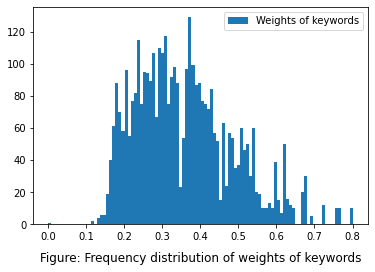

In [61]:
### Visualise ###
ent_w = []
ent_weights = df['keyword_weights']
for ent_weight in ent_weights:
    ent_w = ent_w + ent_weight
hist1 = plt.hist(ent_w, bins=100);
plt.legend(['Weights of keywords'])
plt.title('Figure: Frequency distribution of weights of keywords', y=-0.2);


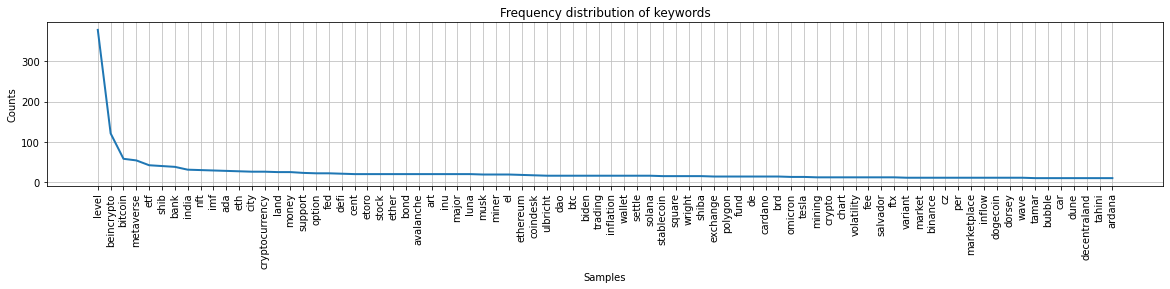

<AxesSubplot:title={'center':'Frequency distribution of keywords'}, xlabel='Samples', ylabel='Counts'>

In [75]:
fdist = FreqDist()
for words in df['keywords'][:]: 
    for word in words:
        fdist[word] += 1
rcParams["figure.figsize"] = (20,3)
fdist.plot(80,title='Frequency distribution of keywords')

## Named Entities

In [43]:
def get_named_entities(df, weights_df):
    ''' 
        TODO next version: Provide cryptocurrencies
        TODO Split function into smaller bits
    '''
    df['entities'] = ''
    df['entities_weight'] = ''
    # Load the spacy dictionary
    nl = en_core_web_sm.load()

    # Provide spacy matches
    for index, row in df.iterrows():
        title = row['title_prepped'] 
        text = row['text_prepped'] 
        full = title + ' ' + text
        full = full.replace("'", ' ')
        full = full.replace(",", ' ')
        full = full.replace("[", ' ')
        full = full.replace("]", ' ')
        doc = nl(full)
        ents = [(X.text, X.label_) for X in doc.ents]
        temp_df = pd.DataFrame(columns=['name', 'weight'])
        # Use this for visualisation of results: displacy.render(doc,style="ent",jupyter=True)
        # Filter relevant entities
        rel_ents = [x[0] for x in ents if (x[1]=='PERSON') or (x[1]=='ORG') or (x[1]=='GPE')]
        # Loop through result and provide weights
        # (i.e. highest weight of individual words in e.g. 'Hillary Clinton')
        # Then, take only those with the 10 highest weights
        f_names = []
        f_weights = []
        for names in rel_ents:
            temp_values = {}
            for name in names.split():
                name = name.lower()
                if name in weights_df.columns:
                    temp_values[name] = weights_df[name][index]
            # proceed if name recognised, otherwise skip
            sorted_temp = sorted(temp_values.items(), key=lambda kv: kv[1], reverse=True)
            if len(sorted_temp) > 0:
                # Store first name and its weight in temporary vectors
                f_names.append(sorted_temp[0][0])
                f_weights.append(sorted_temp[0][1])

        # When done, sort the temporary df and leave the top 10
        # Temporary dataframe to hold weights
        data = {'names':f_names,'weights':f_weights}
        df_temp = pd.DataFrame.from_dict(data).drop_duplicates()
        # Sort and delete all non-top 10
        df_temp = df_temp.sort_values(by=['weights'], ascending=False).drop_duplicates()
        # If not 10 in list, fill with "none" (name) and 0 (weight)
        df_null = pd.DataFrame.from_dict({'names':['none'],'weights':[0]})
        if len(df_temp) < 10:
            x = 10 - len(df_temp)
            for i in range(1, x):
                df_temp = df_temp.append(df_null)
        df_temp = df_temp.head(10)
        df['entities'][index] = list(df_temp['names'])
        df['entities_weight'][index] = list(df_temp['weights'])
    return(df)

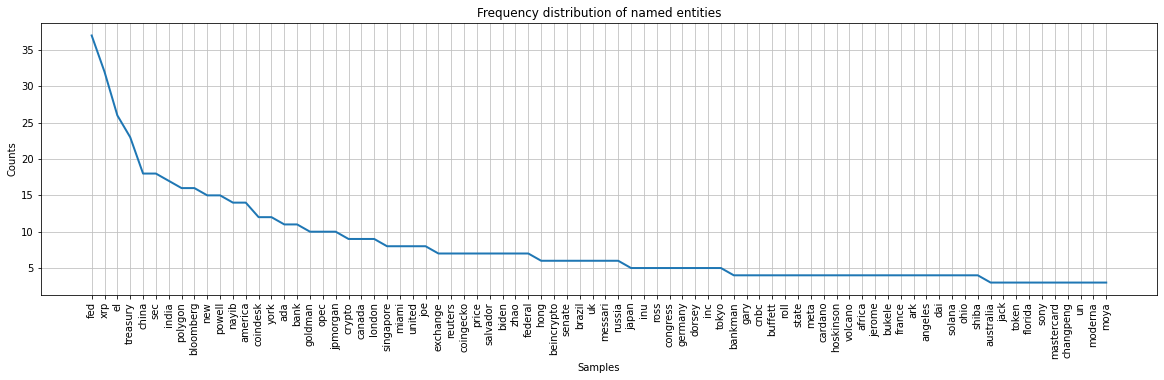

<AxesSubplot:title={'center':'Frequency distribution of named entities'}, xlabel='Samples', ylabel='Counts'>

In [154]:
### VISUALISE if necessary 
# fdist = FreqDist()
# fdist.plot(80,title='Frequency distribution of named entities')
# ent_w = []
# ent_weights = df['entities_weight']
# for ent_weight in ent_weights:
#     ent_w = ent_w + ent_weight
# hist1 = plt.hist(ent_w, bins=60);
# plt.legend(['Weights of extracted entities'])
# plt.title('Figure: Frequency distribution of weights of extracted entities', y=-0.2);

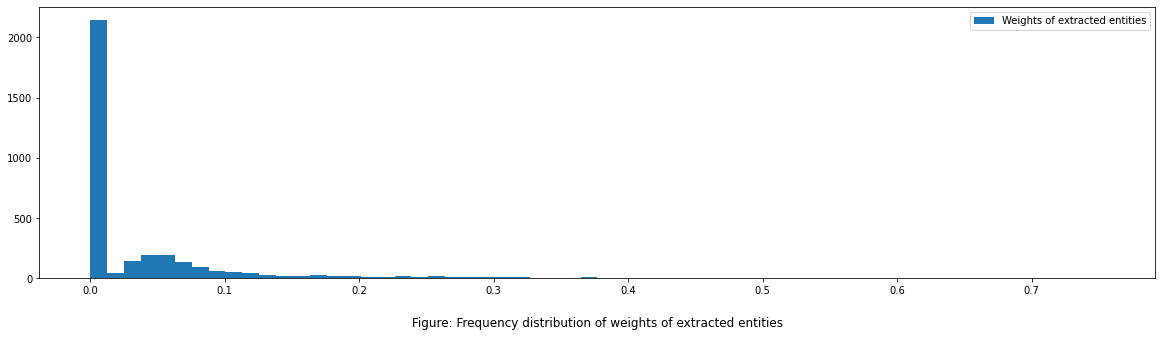

## Sentiment Analysis

In [44]:
def add_sentiments(df):
    # Prepare df:
    df['sent_title'] = ''
    df['sent_text'] = ''
    # Initiate VADER
    sid = SentimentIntensityAnalyzer()
    # Loop through items and get the sentiment scores
    # The compound is saved in df as relevant value
    for index, item in df.iterrows():
        sent_title = sid.polarity_scores(str(item['title']))
        sent_text = sid.polarity_scores(str(item['text']))
        df.loc[index, 'sent_title'] = sent_title['compound']
        df.loc[index, 'sent_text'] = sent_text['compound']
    return df

In [45]:
### Test cell above ###
# df_sents = add_sentiments(df)
# df_sents.head(1)

Text(0.5, -0.2, 'Figure: Distribution of sentiment scores of article titles and body texts')

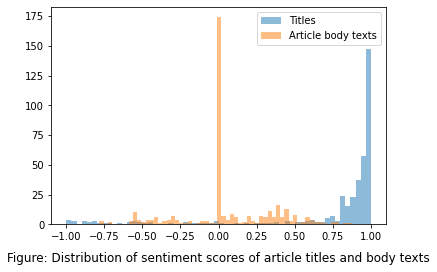

In [46]:
### VISUALIZE when necessary ###
hist1 = plt.hist(df['sent_text'], bins=60, alpha=0.5, label='Titles');
hist2 = plt.hist(df['sent_title'], bins=60, alpha=0.5, label='Body texts');
plt.legend(['Titles', 'Article body texts'])
plt.title('Figure: Distribution of sentiment scores of article titles and body texts', y=-0.2)

## Clustering with DBSCAN

In [194]:
def prepare_for_clustering(df):
    # Extract the numerical value columns as prepared
    exp_df = df[['keyword_weights', 'entities_weight', 'sent_title', 'sent_text']]
    # Spread the arrays into columnar form
    exp = [pd.DataFrame(exp_df[col].tolist()).add_prefix(col) for col in exp_df.columns]
    exp_df = pd.concat([exp[0], exp[1], exp[2], exp[3]], axis= 1)
    exp_df = exp_df.fillna(0)
    # Normalise for output as features for clustering
    features_df = MinMaxScaler().fit_transform(exp_df)

    # Also, create the similarity matrix for model variation (hdbscan)
    sim_matrix = cosine_sim_train = linear_kernel(features_df, features_df)
    return(features_df, sim_matrix)

In [ ]:
### TEST code from cell above ###
# features_df, sim_matrix = prepare_for_clustering(df)
# db = DBSCAN(eps=0.8, min_samples=2).fit(features_df)
# silhouette_score(features_df, labels)

In [ ]:
''' 
Run DBSCAN with parameter spread (eps and min_samples)
This produces errors since, from manual investigation, 
the algorithm would recognise either a label for every
label, or find only noise and one label (0). 
Conclusion: DBSCAN cannot be employed for the task at hand. 
Let's try HDBSCAN thereafter.
'''
maxs = {}
sils = {}
labels = []
fig, axs = plt.subplots(4, 1, figsize=(18, 12))
fig, axs_s = plt.subplots(4, 1, figsize=(18, 12))
# Varying min_samples
for s in range (1,5):
    # Varying eps
    for i in range(1, 50):
        db = DBSCAN(eps=i/10, min_samples=s).fit(features_df)
        labels = db.labels_
        maxs[i/10] = max(labels)
        if max(labels) > 1:
            sils = silhouette_score(features_df, labels)
            sils[i/10] = silh

        if (i > 34) and (i < 40):
            print('min_samples = ' + str(s) +  ' - Eps = ' + str(i/10) + ' - Labels: ' + str(max(db.labels_)) + ' - Silhouett: ' + str(silh))

    names = list(maxs.keys())
    values = list(maxs.values())
    axs[s-1].plot(maxs.keys(), maxs.values())
    axs_s[s-1].plot(sils.keys(), sils.values())
    
fig, axs_f = plt.subplots(4, 1, figsize=(18, 12))

labels_1 = DBSCAN(eps=0.2, min_samples=1).fit(features_df).labels_
labels_2 = DBSCAN(eps=0.6, min_samples=2).fit(features_df).labels_
labels_3 = DBSCAN(eps=0.7, min_samples=3).fit(features_df).labels_
labels_4 = DBSCAN(eps=0.7, min_samples=4).fit(features_df).labels_

axs_f[0].hist(labels_1, bins=50)
axs_f[1].hist(labels_2, bins=50)
axs_f[2].hist(labels_3, bins=50)
axs_f[3].hist(labels_4, bins=50)

In [ ]:
'''
HDBSCAN: Parameter variations rovide results that are more in the space of expectations, i.e. a rather high number of noise (due to many events being presented in news articles over the short time period under investigation) and a rather small number of actual clusters.
'''
hdbs1 = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=None, metric='euclidean', \
                       algorithm='generic', leaf_size=20, prediction_data=True).fit(features_df)
hdbs2 = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean', \
                       algorithm='generic', leaf_size=20, prediction_data=True).fit(features_df)
hdbs3 = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='manhattan', \
                       algorithm='generic', leaf_size=80, prediction_data=True).fit(features_df)

Text(0.04, 0.5, 'Cluster (-1 = noise)')

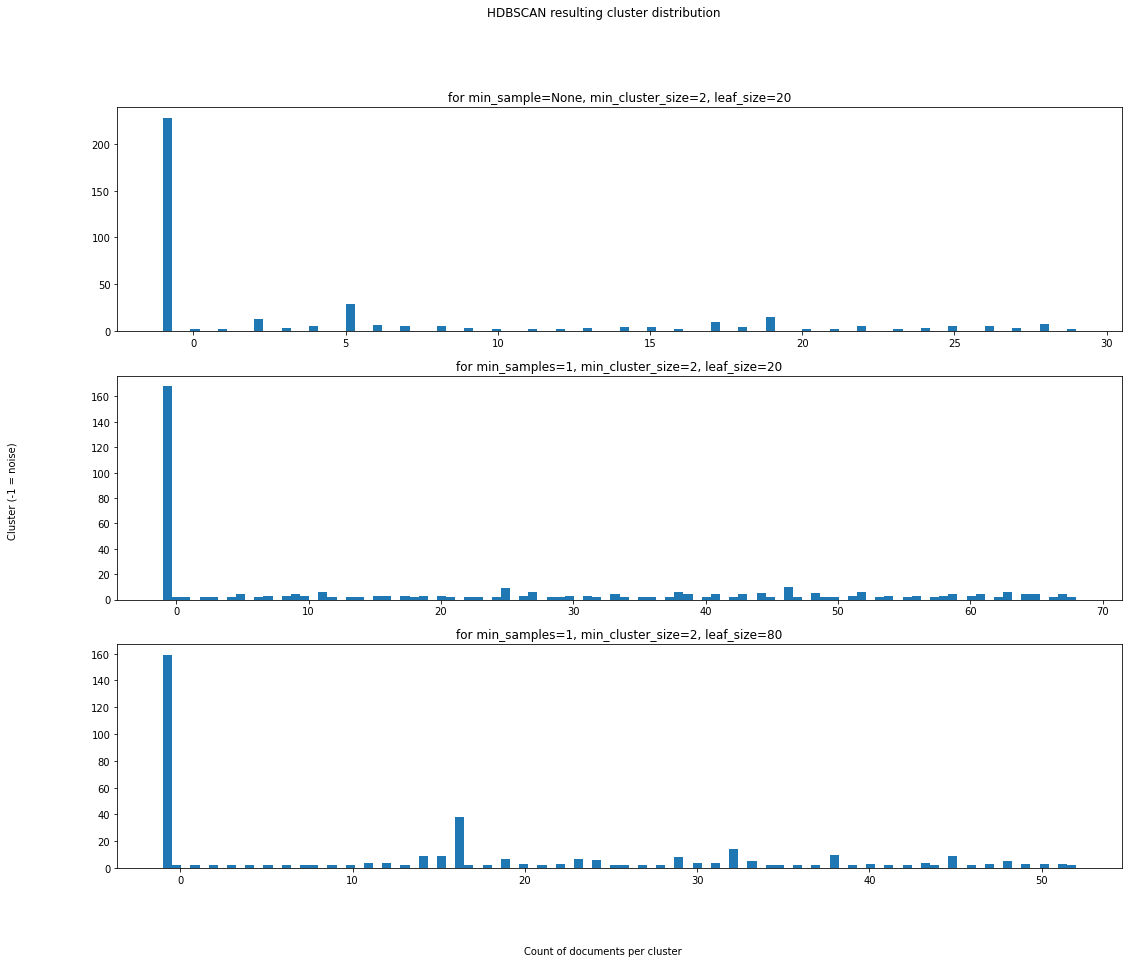

In [224]:

fig, axs = plt.subplots(3, 1, figsize=(18, 14))
plt.suptitle('HDBSCAN resulting cluster distribution')
fig1 = axs[0].hist(hdbs1.labels_, bins=100)
fig2 = axs[1].hist(hdbs2.labels_, bins=100)
fig3 = axs[2].hist(hdbs3.labels_, bins=100)
axs[0].title.set_text('for min_sample=None, min_cluster_size=2, leaf_size=20')
axs[1].title.set_text('for min_samples=1, min_cluster_size=2, leaf_size=20')
axs[2].title.set_text('for min_samples=1, min_cluster_size=2, leaf_size=80')
fig.text(0.5, 0.04, 'Count of documents per cluster', ha='center')
fig.text(0.04, 0.5, 'Cluster (-1 = noise)', va='center', rotation='vertical')

In [818]:
silh1 = silhouette_score(sim_matrix, hdbs1.labels_)
silh2 = silhouette_score(sim_matrix, hdbs2.labels_)
silh3 = silhouette_score(sim_matrix, hdbs3.labels_)
print('Silhouette score for HDBS 1: ' + str(silh1))
print('Silhouette score for HDBS 2: ' + str(silh2))
print('Silhouette score for HDBS 3: ' + str(silh3))

Silhouette score for HDBS 1: 0.182999050414713
Silhouette score for HDBS 2: 0.32098072918032183
Silhouette score for HDBS 3: 0.32098072918032183


In [42]:
def build_model(df, eps, min_samples):
    # Extract the numerical value columns as prepared
    exp_df = df[['keyword_weights', 'entities_weight', 'sent_title', 'sent_text']]
    # Spread the arrays into columnar form
    exp = [pd.DataFrame(exp_df[col].tolist()).add_prefix(col) for col in exp_df.columns]
    exp_df = pd.concat([exp[0], exp[1], exp[2], exp[3]], axis= 1)
    exp_df = exp_df.fillna(0)
    # Normalise
    features_df = MinMaxScaler().fit_transform(exp_df)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(features_df)
    
    return(features_df, db)

In [43]:
def save_hdbscan_model(model):
    # Serialize hdbscan model
    with open('hdbscan_model_r1_1.pickle', 'wb') as handle:
        pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return model

In [44]:
def get_hdbscan_model(file_path):
    # Deserialize hdbscan model
    with open('hdbscan_model_r1_1.pickle', 'rb') as handle:
        hdbscan_model = pickle.load(handle)
    return hdbscan_model

In [45]:
def predict(hdbs, new_data):
    labels, membership_strengths = hdbscan.approximate_predict(hdbs, new_data)
    return(labels, membership_strengths)

## Pipeline

In [56]:
def nlp_pipeline(dataset_path):
    ''' All in one go: Preprocess raw articles texts, 
            visualise + describe corpus, vectorise, add 
            entities + sentiments, build hdbscan model
    '''
    df = preprocess_data(dataset_path)
    df = build_corpus(df)
    #visualise_corpus(df)
    #descriptive_statistics(df)
    tfidf_matrix, vectorizer = get_tfidf(df['merged_corpus'] )
    df, weights_df = add_keywords(df, 10, tfidf_matrix, vectorizer)

    df = get_named_entities(df, weights_df)
    df = add_sentiments(df)
    return(df, tfidf_matrix, vectorizer, weights_df)
# TEST
df, tfidf_matrix, vectorizer, weights_df = nlp_pipeline(dir_path + raw_file_name)
df.head()

TF-IDF matrix shape: (385, 12003)


,title,text,date_time,title_prepped,text_prepped,date,title_corpus,text_corpus,merged_corpus,keywords,keyword_weights,entities,entities_weight,sent_title,sent_text
0,‘Taking no chances:’ Investors abandon travel ...,Stocks tumbled and investors flocked to safe h...,"November 26, 2021, 12:42 AM",taking chance investor abandon travel stock se...,stock tumbled investor flocked safe haven frid...,2021-11-26,"[taking, chance, investor, abandon, travel, st...","[stock, tumbled, investor, flocked, safe, have...",taking chance investor abandon travel stock se...,"[variant, south, south, variant, variant, vari...","[0.26089043502180415, 0.2372423754451628, 0.23...","[south, new, halley, travel, japan, hong, asia...","[0.2372423754451628, 0.16203434176460832, 0.13...",-0.296,-0.97
1,Bitcoin Drops $9K in an Hour on Spot Market Se...,"The price of bitcoin plummeted early Saturday,...","December 4, 2021, 7:41 AM",bitcoin drop hour spot market selling el salva...,price bitcoin plummeted early saturday falling...,2021-12-04,"[bitcoin, drop, hour, spot, market, selling, e...","[price, bitcoin, plummeted, early, saturday, f...",bitcoin drop hour spot market selling el salva...,"[market, market, market, market, market, marke...","[0.25979983108812776, 0.25979983108812776, 0.2...","[el, nayib, fed, none, none, none, none, none,...","[0.13795859734136992, 0.1126830365074132, 0.08...",0.0,-0.8238
2,"Bitcoin falls by a fifth, cryptos see $1 billi...",By Maria Ponnezhath and Vidya Ranganathan(Reut...,"December 4, 2021, 6:56 AM",bitcoin fall fifth cryptos see billion worth l...,maria ponnezhath vidya ranganathan reuters bit...,2021-12-04,"[bitcoin, fall, fifth, cryptos, see, billion, ...","[maria, ponnezhath, vidya, ranganathan, reuter...",bitcoin fall fifth cryptos see billion worth l...,"[vidya, ranganathan, plunge, plunge, anethan, ...","[0.16336089202010992, 0.16336089202010992, 0.1...","[exchange, merriman, justin, bankman, reuters,...","[0.15931459865917627, 0.08168044601005496, 0.0...",0.2263,0.9246
3,Bitcoin’s Mysterious Origins at Center of ‘Fin...,A new documentary is in the works exploring th...,"December 3, 2021, 9:54 AM",bitcoin mysterious origin center finding satos...,new documentary work exploring mysterious foun...,2021-12-03,"[bitcoin, mysterious, origin, center, finding,...","[new, documentary, work, exploring, mysterious...",bitcoin mysterious origin center finding satos...,"[satoshi, film, satoshi, tooley, tooley, cohan...","[0.2287738671587111, 0.2287738671587111, 0.228...","[satoshi, cohan, matthew, tucker, the, ehrsam,...","[0.2287738671587111, 0.20808262593216273, 0.15...",0.0,0.988
4,Expect Bitcoin at $10k if This Happens,The last time we saw Bitcoin’s value at less t...,"December 3, 2021, 9:04 PM",expect bitcoin happens,last time saw bitcoin value le around july las...,2021-12-03,"[expect, bitcoin, happens]","[last, time, saw, bitcoin, value, le, around, ...",expect bitcoin happenslast time saw bitcoin va...,"[asset, asset, navellier, asset, navellier, as...","[0.19556755005817458, 0.19556755005817458, 0.3...","[navellier, fed, cnbc, none, none, none, none,...","[0.3299563989764896, 0.08237979933646407, 0.07...",0.0,0.9787
